In [2]:

import pandas as pd
import io
import re
import csv
import json
import numpy as np
from numpy import savetxt, loadtxt, asarray
from tqdm import tqdm
import math
import ast
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import datasets, layers, models
import matplotlib.patches as mpatches

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model
from random import randrange
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from keras.utils.vis_utils import plot_model
import time
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.externals import joblib 
import seaborn as sns
import glob
#import eli5
#from eli5.sklearn import PermutationImportance


from plot_figures import save_model

pbar = ProgressBar()
tqdm.pandas()

In [3]:


max_blocks = 37 #(36 + 1 FC layer at the end)
nb_param =7
nb_hw_param = 12


inversed = True
only_inversed = False



BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

DATASET_SIZE = 168308
train_size = int(0.90 * DATASET_SIZE) #135 805
test_size = int(0.10 * DATASET_SIZE) # 15 089

nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

In [4]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))

### Load Proccessed Neural Networks (without HyperParameters)

### AWS paths

In [7]:

%pycache
path_entire_model= "/data_predictor/two_power/all_0.279_error/all"
path_raw_val = '/data_predictor/good_data/parsed_nondups_val_3.csv'
path_raw_train = '/data_predictor/good_data/parsed_nondups_train_3.csv'
path_processed_val_nn = '/data_predictor/good_data/val7_from1600.csv'
path_processed_train_nn = '/data_predictor/good_data/train7_from1600.csv'
all_nets = '/data_predictor/good_data/all_nets.json'
more_nets = '/data_predictor/good_data/more_nets'



UsageError: Line magic function `%pycache` not found.


Local paths

In [14]:
#%pycache
path_entire_model= "/Users/roxanefischer/Desktop/a_images/two_power/all_0.279_error/all"
path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_val_3.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_train_3.csv'
path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/val7_from1600.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/train7_from1600.csv'
all_nets = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/DataForHASpredictor2/all_nets.json'
more_nets = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/DataForHASpredictor2'


In [9]:
#%pycache
tin= time.clock()

    
val = pd.read_csv(path_processed_val_nn,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train_nn,converters={'NN_dataframe': from_np_array})

tfin= time.clock()
print(f'Total time : {(tfin-tin)/60} min')

Total time : 1.5308768666666666 min


# Complete to zeros (max shape)

In [17]:
def get_shape(arr):
    return arr.shape[0]

def add_zero_blocks(arr):
    zero_blocks = np.zeros((max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val["nb_blocks"] = val["NN_dataframe"].apply(lambda x : get_shape(x))
train["nb_blocks"] = train["NN_dataframe"].apply(lambda x : get_shape(x))


val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))


In [18]:
def loss_1(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

def loss_2(target_power, predicted_power):
  return tf.math.abs((target_power[:,0] - predicted_power[:,0])/target_power[:,0]) +tf.math.abs((target_power[:,1] - predicted_power[:,1])/target_power[:,1])



# Model

In [19]:
last_layer = 128

multiple_power = True

if multiple_power ==True :
    output_shape = 2
    #train_dataset = train_dataset_mult
    #test_dataset = test_dataset_mult
    loss = loss_2
else :
    output_shape = 1
    #train_dataset = train_dataset_norm
    #test_dataset = test_dataset_norm
    loss = loss_1

#input_blocks = Input(shape=(max_blocks, 1),dtype='float32', name='blocks')
input_nn = Input(shape=(max_blocks, nb_param), dtype='float32', name='input_nn')
output_nn = layers.LSTM(128, return_sequences=True)(input_nn)
output_nn=layers.Dense(last_layer,  activation='relu')(output_nn)
#output_nn = tf.keras.layers.multiply([output_nn, input_blocks])
output_nn =tf.keras.layers.Lambda( lambda x: K.sum(x, axis=1))(output_nn)


model_hw = tf.keras.Sequential([
     layers.Dense(128, activation='relu', input_shape=(nb_hw_param,)),
     layers.Dense(last_layer , activation='linear')
 ])

concat = tf.keras.layers.multiply([output_nn, model_hw.output])
concat = tf.keras.layers.Concatenate()([concat,output_nn, model_hw.output])

output = tf.keras.layers.Dense(units=32, activation='relu')(concat)
output = tf.keras.layers.Dense(units=32, activation='relu')(output)
output = tf.keras.layers.Dense(units=output_shape, activation='relu')(output)
full_model = tf.keras.Model(inputs=[input_nn, model_hw.input], outputs=[output])



output_mult =tf.keras.layers.Lambda( lambda x: K.sum(x, axis=1))(output)
full_model_mult = tf.keras.Model(inputs=[input_nn, model_hw.input], outputs=[output_mult])




Wsave = full_model.get_weights()
print(f'PARAMS : {full_model.count_params()}')

PARAMS : 117762


In [54]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
full_model.compile(optimizer=optimizer, loss=[loss])



### Load weights

In [55]:
full_model.load_weights(path_entire_model)


# Get y_train, y_val


In [21]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)

# HW params

In [22]:
X_train_hw_param  = train_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_train_hw_param['tot_mac'] = X_train_hw_param['mac_num']*X_train_hw_param['mac_array_num']

X_val_hw_param  = val_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_val_hw_param['tot_mac'] = X_val_hw_param['mac_num']*X_val_hw_param['mac_array_num']

X_train_shape = np.array(train["nb_blocks"])
X_val_shape = np.array(val["nb_blocks"])

def inv(x):
    return 1/(1+x)


if inversed : 
#nb_hw_param = 6
    nb_hw_param = 12
    X_train_hw_param['1/mac_num'] = X_train_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/mac_array_num'] = X_train_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/data_bits'] = X_train_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/sram_size'] = X_train_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/max_filter_size'] = X_train_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/tot_mac'] = X_train_hw_param['tot_mac'].progress_apply(lambda x : inv(x))


    X_val_hw_param['1/mac_num'] = X_val_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/mac_array_num'] = X_val_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/data_bits'] = X_val_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/sram_size'] = X_val_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/max_filter_size'] = X_val_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/tot_mac'] = X_val_hw_param['tot_mac'].progress_apply(lambda x : inv(x))

scaler = preprocessing.StandardScaler().fit(X_train_hw_param)
X_train_hw_param_norm= scaler.transform(X_train_hw_param)
X_val_hw_param_norm = scaler.transform(X_val_hw_param )


100%|██████████| 24274/24274 [00:00<00:00, 328031.78it/s]



# NN_params

In [23]:

X_train_nn =np.array(train['NN_dataframe'].tolist())
X_val_nn = np.array(val['NN_dataframe'].tolist())
means = []
std = []
X_train_nn_norm=X_train_nn.copy()
X_val_nn_norm = X_val_nn.copy()
for i in range(nb_param):
    std.append(np.std(X_train_nn[:,:,i]))
    if std[i]!=0:
        X_train_nn_norm[:,:,i]/= std[i]
        X_val_nn_norm[:,:,i]/= std[i]  

savetxt('std.csv', std, delimiter=',')

### Group by different type of power


In [24]:
y_train_core = np.array(train_hw["core_power"].tolist())
y_train_core=y_train_core.reshape(y_train_core.shape[0],-1)

y_val_core = np.array(val_hw["core_power"].tolist())
y_val_core=y_val_core.reshape(y_val_core.shape[0],-1)

y_train_bw = np.array(train_hw["bw_power"].tolist())
y_train_bw=y_train_bw.reshape(y_train_bw.shape[0],-1)

y_val_bw = np.array(val_hw["bw_power"].tolist())
y_val_bw=y_val_bw.reshape(y_val_bw.shape[0],-1)

## Normalize NN names

In [25]:

with open(all_nets, 'r') as f:
    nets_dict = json.load(f)


os.chdir(more_nets)
all_filenames = glob.glob("*.json")
for file in all_filenames:
    with open(more_nets +'/'+ file, 'r') as f:
        file_dict = json.load(f)
        nets_dict.update(file_dict)
len(nets_dict.keys())

def number_zeros(k):
    k = str(int(k))
    nb = len(k)
    return "0"*(8-nb) + k 

def f(mydict):
    return dict( ( number_zeros(k),f(v) if hasattr(v,'keys') else v) for k,v in mydict.items() )


train_hw["name"] = train_hw["name"].progress_apply(lambda x : number_zeros(x))
val_hw["name"] = val_hw["name"].progress_apply(lambda x : number_zeros(x))

100%|██████████| 24274/24274 [00:00<00:00, 414721.77it/s]


## Create dictionnary with network names as key

In [26]:
group_by_train_nn = { }
for k in train_hw["name"].unique():
    indices = train_hw[train_hw["name"]==k].index.to_list()
    group_by_train_nn[k]= {'NN' : X_train_nn_norm[indices], 'HW' :X_train_hw_param_norm[indices], 'Ptot' : y_train[indices], 'Pcore': y_train_core[indices], 'Pbw': y_train_bw[indices]}
    #list_index = 

group_by_val_nn = { }
for k in val_hw["name"].unique():
    indices = val_hw[val_hw["name"]==k].index.to_list()
    group_by_val_nn[k]= {'NN' : X_val_nn_norm[indices], 'HW' :X_val_hw_param_norm[indices], 'Ptot' : y_val[indices], 'Pcore': y_val_core[indices], 'Pbw': y_val_bw[indices]}

# 1) Standard power deviations by network and by type of power

In [27]:

std_pcore_by_nn = {}
std_pbw_by_nn = {}
std_ptot_by_nn = {}
for k in np.sort(train_hw["name"].unique()):
    std_pcore_by_nn[k]=(np.std(group_by_train_nn[k]['Pcore']))
    std_pbw_by_nn[k]=(np.std(group_by_train_nn[k]['Pbw']))
    std_ptot_by_nn[k]=(np.std(group_by_train_nn[k]['Ptot']))



In [28]:
stds = pd.DataFrame((std_pcore_by_nn.items()), columns=['NN_name', 'std_P_core'])
stds['std_P_bw'] = std_pbw_by_nn.values()
stds['std_P_tot'] = std_ptot_by_nn.values()


In [29]:
stds.head()

,NN_name,std_P_core,std_P_bw,std_P_tot
0,00000000,9.985325,13.444819,16.758720
1,00000001,4.082116,7.322100,6.961050
2,00000002,0.786448,0.789838,1.303379
3,00000003,11.971608,43.088050,43.764619
4,00000004,11.929744,31.851902,34.643584


In [30]:
np.mean(stds['std_P_core'])

30.965442373569296

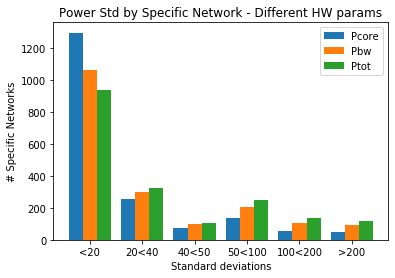

In [31]:
ax = plt.subplot(111)
l =[20,40,50,100,200]
ind = np.arange(len(l)+1)
width = 0.27  



Pcore = [stds['std_P_core'][stds['std_P_core']<l[0] ].count(),]
Pbw = [stds['std_P_bw'][stds['std_P_bw']<l[0] ].count(),]
Ptot = [stds['std_P_tot'][stds['std_P_tot']<l[0] ].count(),]
for i in range(len(l)-1):
    Pcore.append(stds['std_P_core'].loc[ (stds['std_P_core']>l[i]) & (stds['std_P_core']<l[i+1])].count())
    Pbw.append(stds['std_P_bw'].loc[ (stds['std_P_bw']>l[i]) & (stds['std_P_bw']<l[i+1])].count())
    Ptot.append(stds['std_P_tot'].loc[ (stds['std_P_tot']>l[i]) & (stds['std_P_tot']<l[i+1])].count())
Pcore.append(stds['std_P_core'][stds['std_P_core']>l[-1] ].count())
Pbw.append(stds['std_P_bw'][stds['std_P_bw']>l[-1]].count())
Ptot.append(stds['std_P_tot'][stds['std_P_tot']>l[-1] ].count())


core =ax.bar(ind, Pcore,width)
bw =ax.bar(ind+width, Pbw,width)
tot = ax.bar(ind+2*width, Ptot,width)

plt.title('Power Std by Specific Network - Different HW params')
ax.set_xticklabels( ('<20', '20<40','40<50', '50<100','100<200','>200') )
ax.legend( (core[0], bw[0], tot[0]), ('Pcore', 'Pbw', 'Ptot') )
ax.set_ylabel('# Specific Networks')
ax.set_xlabel('Standard deviations')
ax.set_xticks(ind+width)
#ax.xaxis_date()
plt.show()

# 2) Evaluate on full model - by network

In [32]:
# 30 szmple by evzal???
eval_by_NN = {}
for key in group_by_val_nn.keys():
    NN_specific = group_by_val_nn[key]['NN']
    HW_specific = group_by_val_nn[key]['HW']
    Ptot_specific = group_by_val_nn[key]['Ptot']
    eval = full_model.evaluate((NN_specific, HW_specific), Ptot_specific)
    eval_by_NN[key]=eval 


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 1ms/step - loss: 0.6020


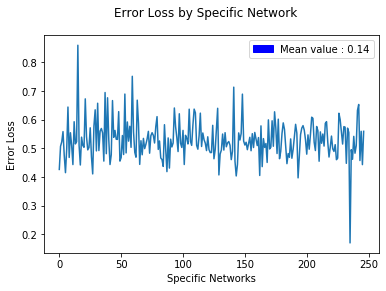

In [33]:

lists = sorted(eval_by_NN.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
#plt.title('Inputs : Specific Network for different HW parameters')
plt.suptitle('Error Loss by Specific Network')
plt.xlabel('Specific Networks')
plt.ylabel('Error Loss')
red_patch = mpatches.Patch(color='blue', label='Mean value : 0.14')
plt.legend(handles=[red_patch])
plt.plot(y)
plt.show()


In [34]:
bad_networks={k: v for (k, v) in eval_by_NN.items() if v>0.14}
good_networks = {k: v for (k, v) in eval_by_NN.items() if v<=0.14}

In [35]:
nets_dict = f(nets_dict)
bad_networks = f(bad_networks)
good_networks = f(good_networks)
eval_by_NN = f(eval_by_NN)


In [36]:
len_bad_NN = []
for k in bad_networks.keys():
    len_bad_NN.append(len(nets_dict[k]))

len_good_NN = []
for k in good_networks.keys():
    len_good_NN.append(len(nets_dict[k]))


# 3) Model Performances over different parameters (#FLOPS, #weights...)

In [37]:
pd_eval = pd.DataFrame(eval_by_NN.items(), columns=['NN_name', 'eval'])
pd_eval['NN']= pd_eval['NN_name'].apply(lambda x : nets_dict[x])
pd_eval['nb_blocks']= pd_eval['NN_name'].apply(lambda x : len(nets_dict[x]))
pd_eval['c_outs']=pd_eval['NN'].apply(lambda x : np.array(x)[:,1].astype('float64'))
pd_eval['sum_c_outs']=pd_eval['c_outs'].apply(lambda x : sum(x))
pd_eval['treated_NN']=pd_eval['NN_name'].apply(lambda x : group_by_val_nn[x]['NN'][0] )
pd_eval['nb_samples']=pd_eval['NN_name'].apply(lambda x : len(group_by_val_nn[x]['NN']) )
pd_eval['tot_FLOPS']=pd_eval['treated_NN'].apply(lambda x : np.sum((x)[:,0]))
pd_eval['tot_weights']=pd_eval['treated_NN'].apply(lambda x : np.sum((x)[:,1]))
pd_eval['mean_FLOPS']=pd_eval['treated_NN'].apply(lambda x : np.mean((x)[:,0]))
pd_eval['mean_weights']=pd_eval['treated_NN'].apply(lambda x : np.mean((x)[:,1]))
pd_eval['mean_tot_mac']=pd_eval['NN_name'].apply(lambda x : np.mean(group_by_val_nn[x]['HW'][:,5]))



In [38]:
pd_eval = pd_eval.sort_values(by=['eval'])
pd_eval

,NN_name,eval,NN,nb_blocks,c_outs,sum_c_outs,treated_NN,nb_samples,tot_FLOPS,tot_weights,mean_FLOPS,mean_weights,mean_tot_mac
201,00002311,0.170457,"[[1, 31, 2, 3, 0, conv], [1, 31, 1, 3, 0, dw],...",18,"[31.0, 31.0, 24.0, 64.0, 66.0, 49.0, 62.0, 59....",1994.0,"[[0.07556604681507831, 0.0018824394966463313, ...",6,92.105520,12.070820,2.489338,0.326238,0.657720
232,00001913,0.397341,"[[1, 11, 2, 3, 0, conv], [1, 11, 1, 3, 0, dw],...",18,"[11.0, 11.0, 13.0, 43.0, 43.0, 63.0, 63.0, 63....",2541.0,"[[0.026813758547285852, 0.000667962402035795, ...",26,3.589822,6.113083,0.097022,0.165218,2.684700
102,00001428,0.404040,"[[1, 11, 2, 3, 0, conv], [1, 11, 1, 3, 0, dw],...",12,"[11.0, 11.0, 14.0, 25.0, 36.0, 36.0, 36.0, 36....",965.0,"[[0.026813758547285852, 0.000667962402035795, ...",99,2.043677,1.542158,0.055235,0.041680,-0.226449
205,00001606,0.405718,"[[1, 20, 2, 3, 0, conv], [1, 20, 1, 3, 0, dw],...",15,"[20.0, 20.0, 15.0, 48.0, 102.0, 102.0, 102.0, ...",2943.0,"[[0.04875228826779246, 0.0012144770946105363, ...",53,39.299945,7.152619,1.062161,0.193314,0.391686
148,00001288,0.407581,"[[1, 29, 2, 3, 0, conv], [1, 29, 1, 3, 0, dw],...",22,"[29.0, 29.0, 9.0, 18.0, 18.0, 18.0, 44.0, 44.0...",4342.0,"[[0.07069081798829907, 0.0017609917871852776, ...",2,39.453996,32.715781,1.066324,0.884210,-0.264296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,00000559,0.689643,"[[1, 11, 2, 3, 0, conv], [1, 11, 1, 3, 0, dw],...",18,"[11.0, 11.0, 26.0, 4.0, 6.0, 6.0, 11.0, 9.0, 1...",523.0,"[[0.026813758547285852, 0.000667962402035795, ...",97,0.927953,0.780484,0.025080,0.021094,-0.203438
37,00000395,0.694987,"[[1, 22, 2, 3, 0, conv], [1, 22, 1, 3, 0, dw],...",11,"[22.0, 22.0, 9.0, 40.0, 40.0, 46.0, 80.0, 131....",1597.0,"[[0.053627517094571704, 0.00133592480407159, 1...",74,9.305723,4.073291,0.251506,0.110089,0.214910
146,00001381,0.713721,"[[1, 37, 2, 3, 0, conv], [1, 37, 1, 3, 0, dw],...",17,"[37.0, 37.0, 16.0, 6.0, 6.0, 6.0, 6.0, 7.0, 8....",933.0,"[[0.09019173329541605, 0.0022467826250294923, ...",71,0.783890,1.522243,0.021186,0.041142,-0.290088
59,00000591,0.751635,"[[1, 28, 2, 3, 0, conv], [1, 28, 1, 3, 0, dw],...",21,"[28.0, 28.0, 15.0, 27.0, 27.0, 27.0, 27.0, 27....",1914.0,"[[0.06825320357490944, 0.0017002679324547509, ...",17,17.764731,5.155035,0.480128,0.139325,0.871079


[None]

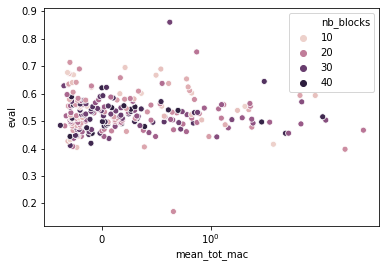

In [39]:


splot =sns.scatterplot(data=pd_eval[['mean_tot_mac','eval','nb_blocks']], x='mean_tot_mac', y='eval', hue='nb_blocks')
splot.set(xscale="symlog")


#pd_eval.plot(x='sum_c_outs', y='eval',style='o')

[None]

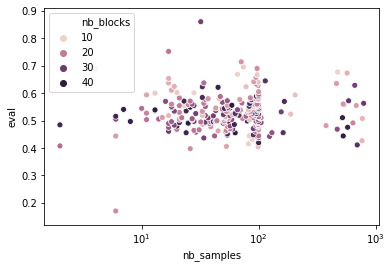

In [40]:
splot = sns.scatterplot(data=pd_eval[['nb_samples','eval','nb_blocks']], x='nb_samples', y='eval', hue='nb_blocks')
splot.set(xscale="symlog")

[None]

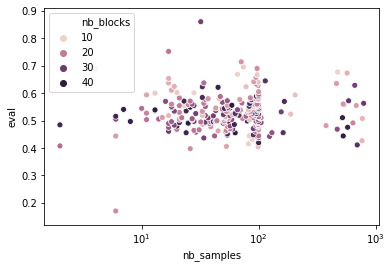

In [41]:
splot = sns.scatterplot(data=pd_eval[['nb_samples','eval','nb_blocks']], x='nb_samples', y='eval', hue='nb_blocks')
splot.set(xscale="symlog")

[None]

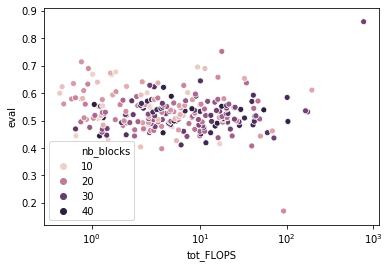

In [42]:
splot = sns.scatterplot(data=pd_eval[['tot_FLOPS','eval','nb_blocks']], x='tot_FLOPS', y='eval', hue='nb_blocks')
splot.set(xscale="symlog")

[None]

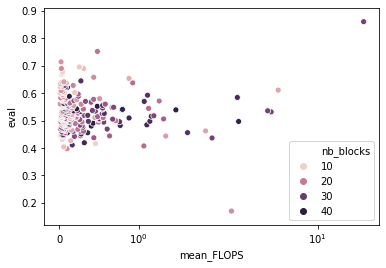

In [43]:
splot=sns.scatterplot(data=pd_eval[['mean_FLOPS','eval','nb_blocks']], x='mean_FLOPS', y='eval', hue='nb_blocks')
splot.set(xscale="symlog")

[None]

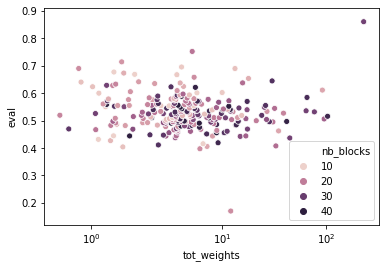

In [44]:
splot =sns.scatterplot(data=pd_eval[['tot_weights','eval','nb_blocks']], x='tot_weights', y='eval', hue='nb_blocks')
splot.set(xscale="symlog")

[None]

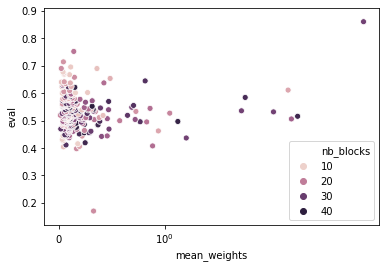

In [45]:
splot = sns.scatterplot(data=pd_eval[['mean_weights','eval','nb_blocks']], x='mean_weights', y='eval', hue='nb_blocks')
splot.set(xscale="symlog")

In [52]:
dict((k,v) for k,v in bad_networks.items())

{'00000006': 0.4267410337924957,
 '00000011': 0.5072065591812134,
 '00000014': 0.5232851505279541,
 '00000022': 0.5586519837379456,
 '00000029': 0.47552812099456787,
 '00000045': 0.41550958156585693,
 '00000053': 0.4982396066188812,
 '00000065': 0.6443347334861755,
 '00000068': 0.4684854745864868,
 '00000088': 0.5546784400939941,
 '00000090': 0.5099071264266968,
 '00000092': 0.443719744682312,
 '00000113': 0.5931756496429443,
 '00000127': 0.5157178640365601,
 '00000133': 0.5235260725021362,
 '00000149': 0.8599072098731995,
 '00000158': 0.5106247663497925,
 '00000161': 0.442256897687912,
 '00000164': 0.5393333435058594,
 '00000176': 0.5103358626365662,
 '00000227': 0.5039794445037842,
 '00000229': 0.6729002594947815,
 '00000233': 0.5413429737091064,
 '00000238': 0.4949623942375183,
 '00000259': 0.5032999515533447,
 '00000270': 0.5718958973884583,
 '00000281': 0.47076356410980225,
 '00000284': 0.41113606095314026,
 '00000288': 0.5785881280899048,
 '00000314': 0.6346960067749023,
 '000003

## 10,785 params:
### 25 epochs : 56 min
### 15 epochs : 34 min
</br>

## 31 000
### **20 epochs : 25 min**
 </br>

## 57,009 params
### 20 epochs : 101 min 
</br>

##62,465 pames
### 30 epochs : 78 min
 </br>

## 143,345 params
### 20 epochs : 276 min 
</br>

